# Introduction

Convolutional neural networks are cool because the nature of the "convolution" adds the property of translational invariance to image recognition tasks - e.g. it doesn't matter where in the image we are, we can still recognize if an object is "there".

New ideas:

## Convolution

A kernel is centered over a pixel in the source image. A kernel is a tensor of weights - each corresponding weight and pixel (within the 'view' of the kernel) are multiplied together and summed. This is done for each pixel in the image to create a new convoluted image. For edge pixels, we can use zero-padding.

## Max-Pooling

Max-pooling is the process of simplifying the data in an input image by summarizing data in uniform regions. Max-pooling operates on the convoluted image by scanning across the convoluted image in strides, selecting the maximum value per pooling region.

## Keywords

* CNN: Convolutional Neural Network
* Convolution: applying a kernel (convolution) to a tensor
* Kernel / Filter: A matrix which is smaller than the input
* Padding: literal padding for convolutions at the edge of the image
* Pooling: step after convolution where the convolution is downsampled using a pooling strategy
* Stride: number of pixels to slide the kernel (filter) across the image
* Downsampling: Reducing the size of an image.

# Fashion MNIST - Once Again

In [1]:
import tensorflow as tf

# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
print(tf.__version__)

2.3.0


In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [40]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [41]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [6]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

Show N Images

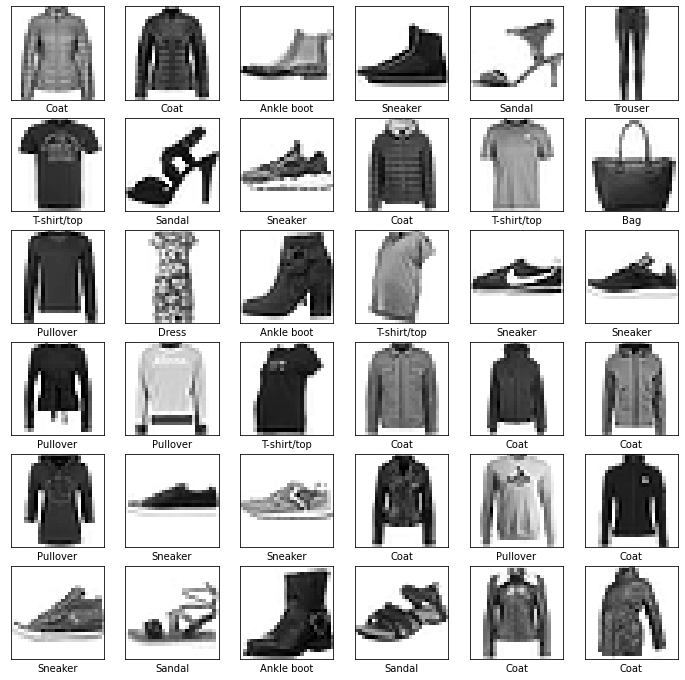

In [42]:
N = 6
scale = 2
fig, ax = plt.subplots(nrows=N, ncols=N, figsize=(N*scale, N*scale))
idx = [(i, j) for i in range(N) for j in range(N)]

for i, (img, label) in enumerate(test_dataset.take(N*N)):
  image = img.numpy().reshape((28, 28))
  ax[idx[i]].set_xticks([])
  ax[idx[i]].set_yticks([])
  ax[idx[i]].imshow(image, cmap=plt.cm.binary)
  ax[idx[i]].set_xlabel(class_names[label])

In [43]:
# Train Config
BATCH_SIZE = 32

# repeat configures the dataset to repeat indefinitely and be shuffled - 
# basically creating infinite random batches from the training data. Assuming
# that we get 'perfect' shuffling so that the number of training examples 
# specifies the 'width' of shuffling.
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Now, we make a new, convolutional model!

# New Stuff

- Note that we have invoked two new layer types: Conv2D and MaxPooling2D. Essentially we have added two layers of convolutions prior to flattening the input and proceeding as before with a dense layer and softmax to obtain probabilities for each class.

## [`tf.keras.layers.Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

```python
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    dilation_rate=(1, 1), groups=1, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, bias_constraint=None, **kwargs
)
```

Here, we set the dimensionality of the output space of the convolution with the `filters` argument - this just means that we'll have 32 output filters after this layer, and use a kernel size specified in pixels as the height/width of the 2D convolution window - in this case its 3 by 3.

So, we will take an image from a 28 by 28, and perform 2D convolutions for each pixel in a square around the central pixels. Because we have 32 output filters, this means, effectively, that we'll have 32 output images of the same size as the input image from the first `Conv2D` layer.

Each of the 32 outputs are reduced using a `MaxPooling2D` using a (2, 2) window with a stride of 2.



In [49]:
def make_model(n_dense=128):
  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(n_dense, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
  ])
  
  model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )
  
  return model


In [51]:
model = make_model(n_dense=128)

In [52]:
# BATCH_SIZE controls the number of samples used to estimate the gradient.
# An epoch is a pass through the training set.
# The steps per epoch defines now many batches to pull from the training set per epoch.

# Original:
#history = model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

history = model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))


Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5131 - accuracy: 0.8607
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2668 - accuracy: 0.9013
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2369 - accuracy: 0.9124
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2120 - accuracy: 0.9225
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1940 - accuracy: 0.9273
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1737 - accuracy: 0.9344
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1561 - accuracy: 0.9419
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1464 - accuracy: 0.9459
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1279 - accuracy: 0.9531
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.117

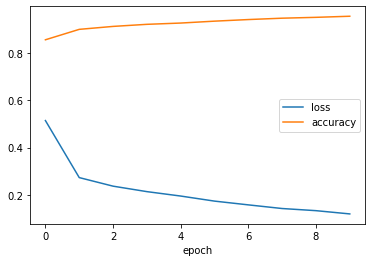

In [47]:
h = pd.DataFrame(history.history)
h['epoch'] = history.epoch
h = h.set_index('epoch')
h.plot()

Recalling before, we had a best accuracy of something like 89%, however here we have achieved an accuracy of 97.5% - nearly 20% better by adding convolutions. Of course, we must evaluate on the test dataset.

In [48]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print("Accuracy of test dataset: {}".format(test_accuracy))

313/313 [==============================] - 1s 2ms/step - loss: 0.4005 - accuracy: 0.9025
Accuracy of test dataset: 0.9024999737739563


Okay, so about 5% worse on the test dataset. The reason for this is that the model has over-fit (memorized) the training dataset. However, we don't see such a clear example as when we looked at the AutoMPG dataset - where we could see growing loss over time (e.g. getting actively worse).

# Exercises

Experiment with different models and see how the accuracy results differ. In particular change the following parameters:
*   Set training epochs set to 1
*   Number of neurons in the Dense layer following the Flatten one. For example, go really low (e.g. 10) in ranges up to 512 and see how accuracy changes
*   Add additional Dense layers between the Flatten and the final Dense(10), experiment with different units in these layers
*   Don't normalize the pixel values, and see the effect that has


Remember to enable GPU to make everything run faster (Runtime -> Change runtime type -> Hardware accelerator -> GPU).
Also, if you run into trouble, simply reset the entire environment and start from the beginning:
*   Edit -> Clear all outputs
*   Runtime -> Reset all runtimes

## Exercise 1 - Set number of epochs to 1

It seems like the first run through over-fits the dataset - the loss after 10 epochs is very small, but we still have about 0.3 on the test set. However, when we set the number of epochs to 1, the train loss and test loss are about the same.

Lets look at how the test loss changes with the number of epochs (we know train loss will diminish)


## Exercise 2 - Number of neurons in the Dense layer following first Flatten

When the number of neurons in the dense layer is small, the loss drops more slowly, but the final test loss is also a bit lower.

When the number of neurons in the dense layer is very large (1000), the loss drops quickly and the training accuracy becomes very high. The test loss is higher than training more significantly, perhaps indicating over-fitting.


## Exercise 3 - Adding more dense layers

Adding more dense layers (but keeping them small-ish) seems to be similar to just keeping them small-ish (20)

- Keeping same layers, but alternating between softmax and relu makes the performance garbage. Loss starts above 1, and then slowly drops.

Totally removing the dense layer gets us about back to the original config.

## Exercise 4 - don't normalize the data

- The test loss was doubled relative to the base case.

# TODO: Visualizing intermediate outputs

In [54]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               401536    
_________________________________________________________________
dense_27 (Dense)             (None, 10)               